In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import re


In [2]:
def parse_gpw_text(filename, n=5):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Find Fermi level
    fermi_level = None
    for line in lines:
        if "Fermi level:" in line:
            fermi_level = float(line.split(":")[1].strip())
            break

    if fermi_level is None:
        raise ValueError("Fermi level not found.")

    # Find band energies and occupancies
    band_start = None
    for i, line in enumerate(lines):
        if re.match(r"\s*Band\s+Eigenvalues\s+Occupancy", line):
            band_start = i + 1
            break

    if band_start is None:
        raise ValueError("Band energies section not found.")

    energies = []
    occupancies = []
    for line in lines[band_start:]:
        if not line.strip() or not re.match(r"\s*\d+", line):
            break
        parts = line.split()
        energy = float(parts[1])
        occ = float(parts[2])
        energies.append(energy)
        occupancies.append(occ)

    # Find index closest to Fermi level
    idx = min(range(len(energies)), key=lambda i: abs(energies[i] - fermi_level))

    # Extract ±n levels
    start = max(idx - n, 0)
    end = min(idx + n + 1, len(energies))
    selected_energies = energies[start:end]
    selected_occupancies = occupancies[start:end]

    return fermi_level, np.array(selected_energies), np.array(selected_occupancies)
def compute_dos(energies, occupancies, energy_range=None, n_points=1000, smearing=0.1):
    """
    Compute Density of States (DOS) using Gaussian broadening.

    Parameters
    ----------
    energies : array-like
        List or array of energy levels (eigenvalues).
    occupancies : array-like
        List or array of occupancy values corresponding to each energy.
    energy_range : tuple, optional
        (Emin, Emax) range over which to compute DOS. If None, auto-determined.
    n_points : int
        Number of energy points in DOS plot.
    smearing : float
        Broadening width in eV.

    Returns
    -------
    energy_grid : ndarray
        Grid of energy values.
    dos : ndarray
        Density of states corresponding to the energy grid.
    """
    energies = np.array(energies)
    occupancies = np.array(occupancies)

    if energy_range is None:
        Emin = energies.min() - 2 * smearing
        Emax = energies.max() + 2 * smearing
    else:
        Emin, Emax = energy_range

    energy_grid = np.linspace(Emin, Emax, n_points)
    dos = np.zeros_like(energy_grid)

    for e, occ in zip(energies, occupancies):
        dos += np.exp(-0.5 * ((energy_grid - e) / smearing)**2)

    # Normalize each Gaussian
    dos /= (smearing * np.sqrt(2 * np.pi))

    return energy_grid, dos


Fermi level: -5.88873
Energies: [-7.24662 -7.24147 -7.23841 -7.22965 -7.22866 -7.2233  -7.14467 -7.14318
 -7.13632 -7.13357 -7.10173 -7.07366 -7.03964 -7.03339 -7.0317  -6.97566
 -6.96535 -6.96029 -6.90869 -6.86446 -6.85978 -6.85538 -6.83391 -6.83313
 -6.82941 -6.75207 -6.72344 -6.72103 -6.71579 -6.71225 -6.65838 -6.64045
 -6.64025 -6.5842  -6.58245 -6.5759  -6.57499 -6.53349 -6.52523 -6.52504
 -6.34424 -6.2198  -6.21971 -6.21807 -6.21658 -6.19653 -6.19602 -6.19502
 -6.19453 -6.13618 -6.13614 -6.13498 -6.13487 -6.11363 -6.057   -6.0568
 -6.04253 -6.04163 -5.96856 -5.96824 -5.96793 -5.96782 -5.91711 -5.89978
 -5.89948 -5.8994  -5.8991  -5.89906 -5.89856 -5.89788 -5.89337 -5.88231
 -5.88227 -5.88199 -5.88179 -5.88148 -5.88049 -5.85745 -5.85737 -5.85732
 -5.85722 -5.85533 -5.85509 -5.85498 -5.85474 -5.58382 -5.5837  -5.28117
 -5.28064 -5.27875 -5.2782  -5.27122 -5.2699  -5.12477 -5.11906 -5.11203
 -5.00224 -4.99666 -4.99427 -4.95828 -4.95663 -4.93936 -4.93912 -4.93591
 -4.93542 -4.88097 -

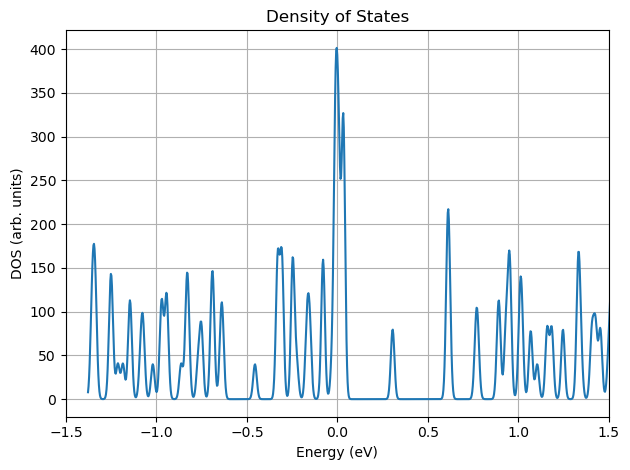

In [5]:
fermi, energies, occupancies = parse_gpw_text('./device/scatt.txt', n=70)
print("Fermi level:", fermi)
print("Energies:", energies)
print("Occupancies", occupancies)
energies -= fermi
energy_grid, dos = compute_dos(energies, occupancies, smearing=0.01)

plt.plot(energy_grid, dos)
plt.xlabel("Energy (eV)")
plt.ylabel("DOS (arb. units)")
plt.title("Density of States")
plt.grid(True)
plt.xlim(-1.5,1.5)
# plt.ylim(top=90)
plt.tight_layout()
plt.show()


### Using GPAW's internal mechanism to compute DOS

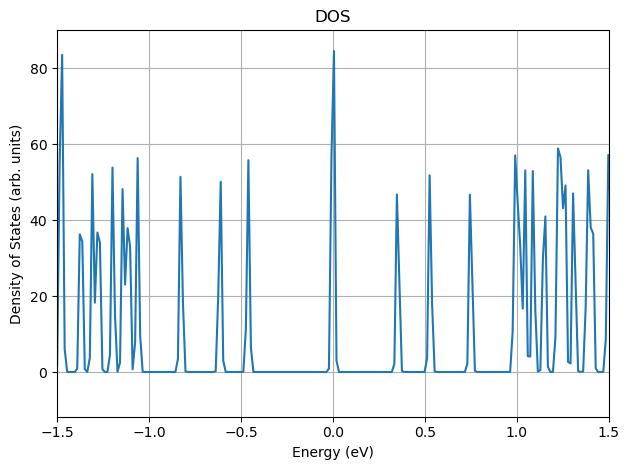

In [6]:
data = np.loadtxt("bridge/dos.dat", comments="#")
energies = data[:, 0]
dos = data[:, 1]

plt.plot(energies, dos)
plt.xlabel("Energy (eV)")
plt.ylabel("Density of States (arb. units)")
plt.title("DOS")
plt.grid(True)
plt.xlim(-1.5,1.5)
plt.ylim(top=90)
plt.tight_layout()
plt.show()